In [1]:
%load_ext pretty_jupyter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [8]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [9]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [10]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [11]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [12]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

In [13]:
def cluster_means(adata, clusters):
    obs_clusters = adata.obs.groupby(clusters)
    
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(obs_clusters)), dtype=np.float64),
        columns = list(obs_clusters.groups.keys()),
        index = adata.var.index
    )

    for group, idx in obs_clusters.indices.items():
        X = adata.X[idx]
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [14]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Markers for dotplots

In [15]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [16]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [17]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [18]:
original_df.head()

barcodes original_L1 original_L2 original_L3
0  05ea9806794211eb93b836d1cb6129eb          DC        cDC1        cDC1
1  e225c914794011eb9282e2ceeb91ba52          DC        cDC1        cDC1
2  b1379eae795411eb958b0245821e6993          DC        cDC1        cDC1
3  b13d3a8a795411eb958b0245821e6993          DC        cDC1        cDC1
4  b1430d16795411eb958b0245821e6993          DC        cDC1        cDC1

## Read cell type hierarchy

In [19]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [20]:
search_id = 'mercury-polonium-zinc'

Retrieve files stored in our HISE project store

In [21]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [22]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [23]:
search_df['AIFI_L3'].tolist()

['CD4 reasons',
 'CM CD4 T cell',
 'Core naive CD4 T cell',
 'GZMB- CD27- EM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'ISG+ memory CD4 T cell',
 'ISG+ naive CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'SOX4+ naive CD4 T cell']

## Review CM CD4 T cell

In [24]:
cell_type = 'CM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [25]:
type_uuid

'2b15968b-f476-4e83-9730-7e5d975611a6'

In [26]:
adata = read_adata_uuid(type_uuid)

### Clustering

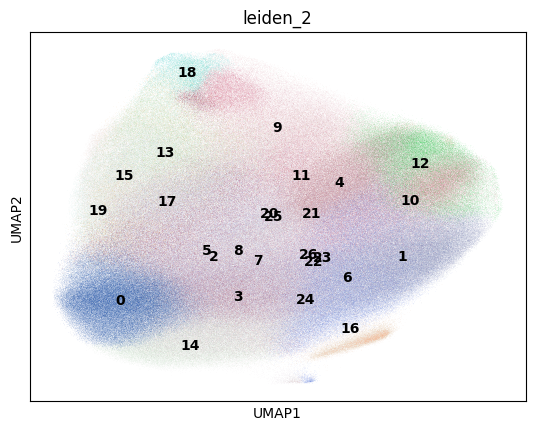

In [27]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

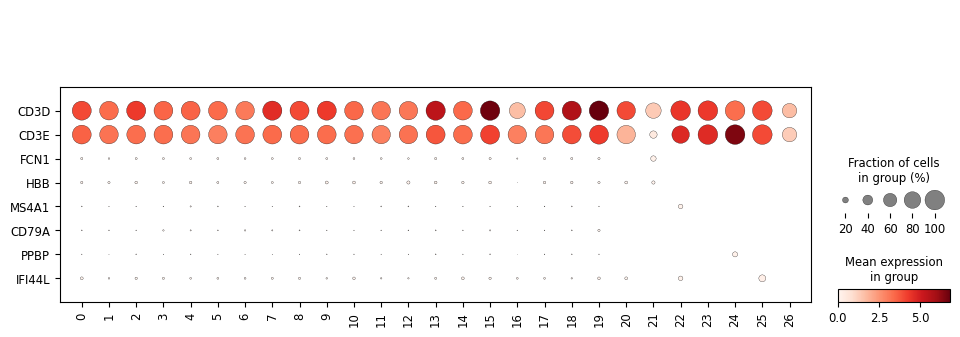

In [28]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

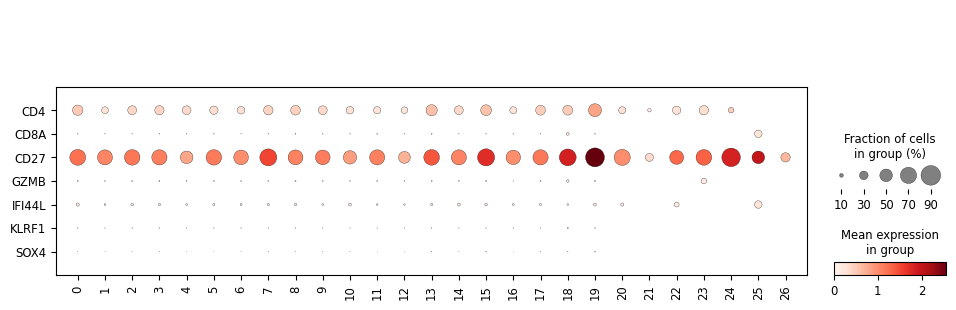

In [29]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [30]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     131146
1     117117
2      99997
3      97499
4      93929
5      87676
6      79567
7      78453
8      75070
9      74309
10     69935
11     69295
12     61546
13     57418
14     45825
15     42367
16     29150
17     26849
18     11082
19     10041
20        13
21        11
22         7
23         6
24         6
25         4
26         3
Name: count, dtype: int64

### Comparison to original labels

In [31]:
adata = add_labels(adata, original_df)

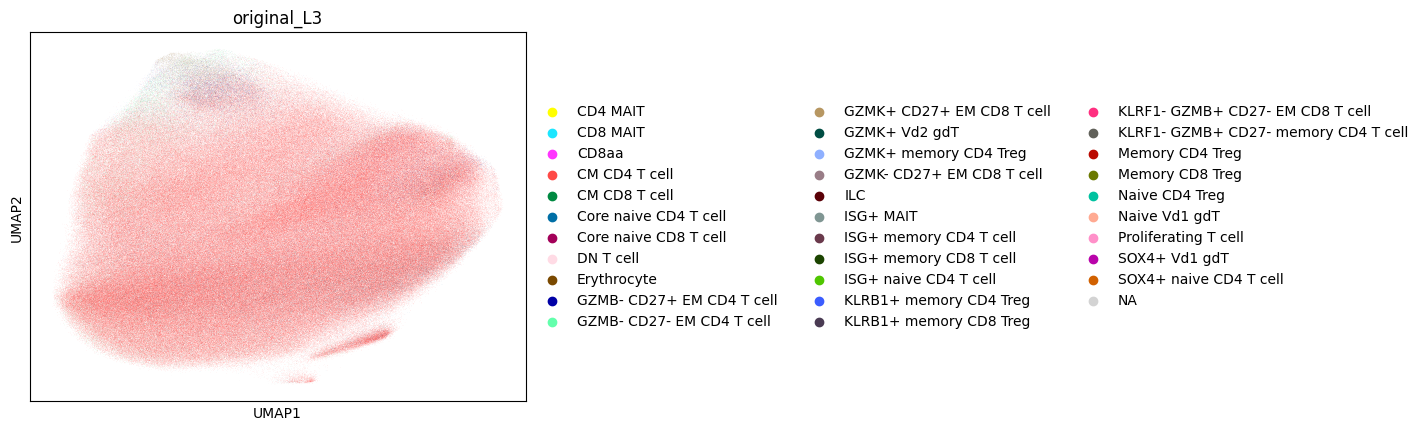

In [32]:
sc.pl.umap(adata, color = 'original_L3')

In [33]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CM CD4 T cell                           1232665
GZMB- CD27- EM CD4 T cell                 37236
Core naive CD4 T cell                     35974
GZMB- CD27+ EM CD4 T cell                 24174
GZMK+ CD27+ EM CD8 T cell                  6254
NaN                                        5937
Naive CD4 Treg                             4714
GZMK+ memory CD4 Treg                      3431
KLRB1+ memory CD4 Treg                     1936
CM CD8 T cell                              1695
Memory CD4 Treg                            1606
ISG+ memory CD4 T cell                      893
ISG+ naive CD4 T cell                       660
Proliferating T cell                        543
DN T cell                                   193
Core naive CD8 T cell                        99
SOX4+ naive CD4 T cell                       67
Naive Vd1 gdT                                53
GZMK- CD27+ EM CD8 T cell                    30
ISG+ memory CD8 T cell                       27
KLRB1+ memory CD8 Treg      

In [34]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CM CD4 T cell                           9.074917e-01
GZMB- CD27- EM CD4 T cell               2.741326e-02
Core naive CD4 T cell                   2.648417e-02
GZMB- CD27+ EM CD4 T cell               1.779697e-02
GZMK+ CD27+ EM CD8 T cell               4.604214e-03
NaN                                     4.370837e-03
Naive CD4 Treg                          3.470461e-03
GZMK+ memory CD4 Treg                   2.525913e-03
KLRB1+ memory CD4 Treg                  1.425289e-03
CM CD8 T cell                           1.247864e-03
Memory CD4 Treg                         1.182342e-03
ISG+ memory CD4 T cell                  6.574293e-04
ISG+ naive CD4 T cell                   4.858940e-04
Proliferating T cell                    3.997582e-04
DN T cell                               1.420872e-04
Core naive CD8 T cell                   7.288410e-05
SOX4+ naive CD4 T cell                  4.932560e-05
Naive Vd1 gdT                           3.901876e-05
GZMK- CD27+ EM CD8 T cell         

## Review Core naive CD4 T cell

In [35]:
cell_type = 'Core naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [36]:
type_uuid

'f3f6c636-cadd-48e0-b3a7-e38254d7897c'

In [37]:
adata = read_adata_uuid(type_uuid)

### Clustering

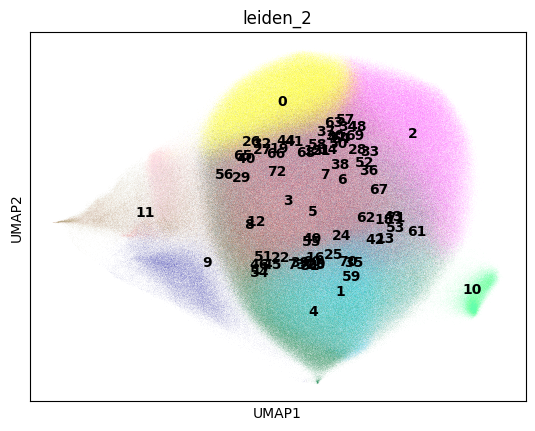

In [38]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

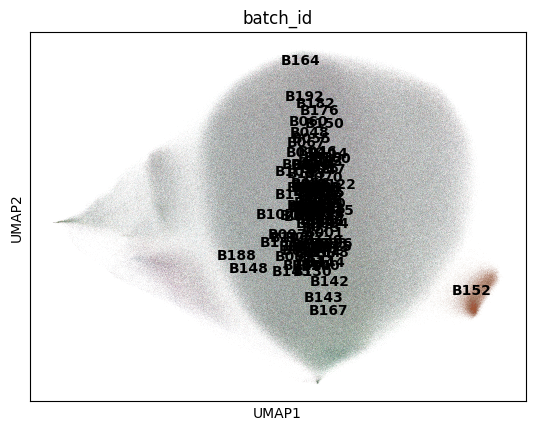

In [39]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

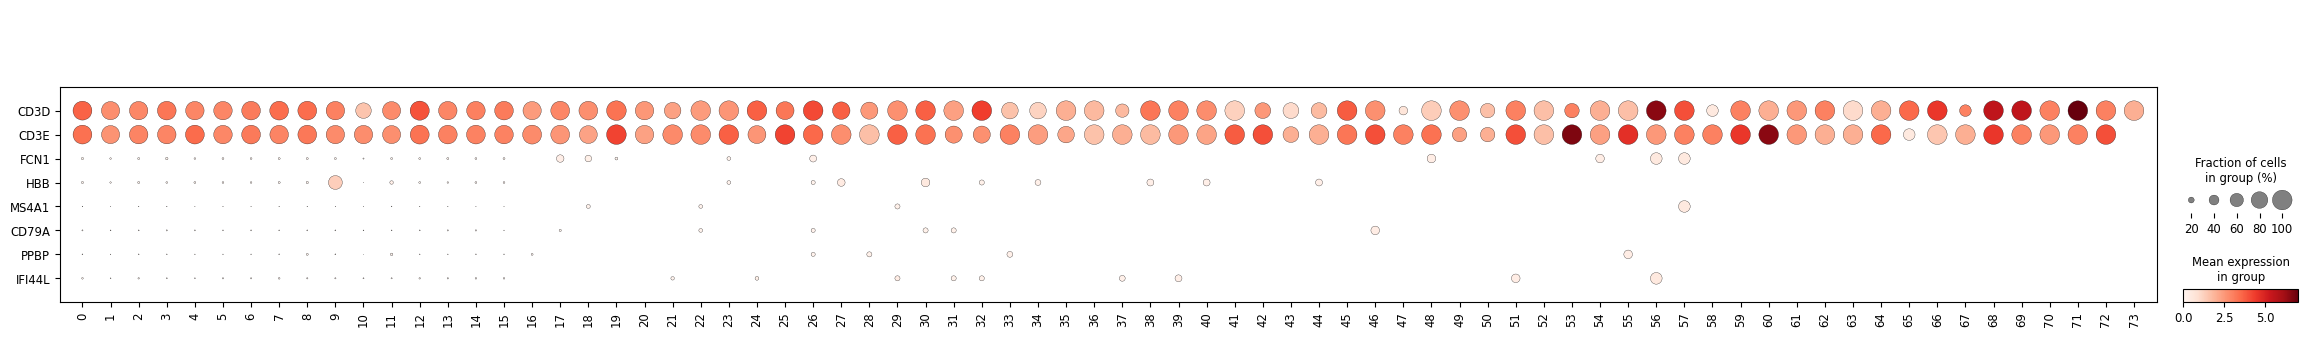

In [40]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

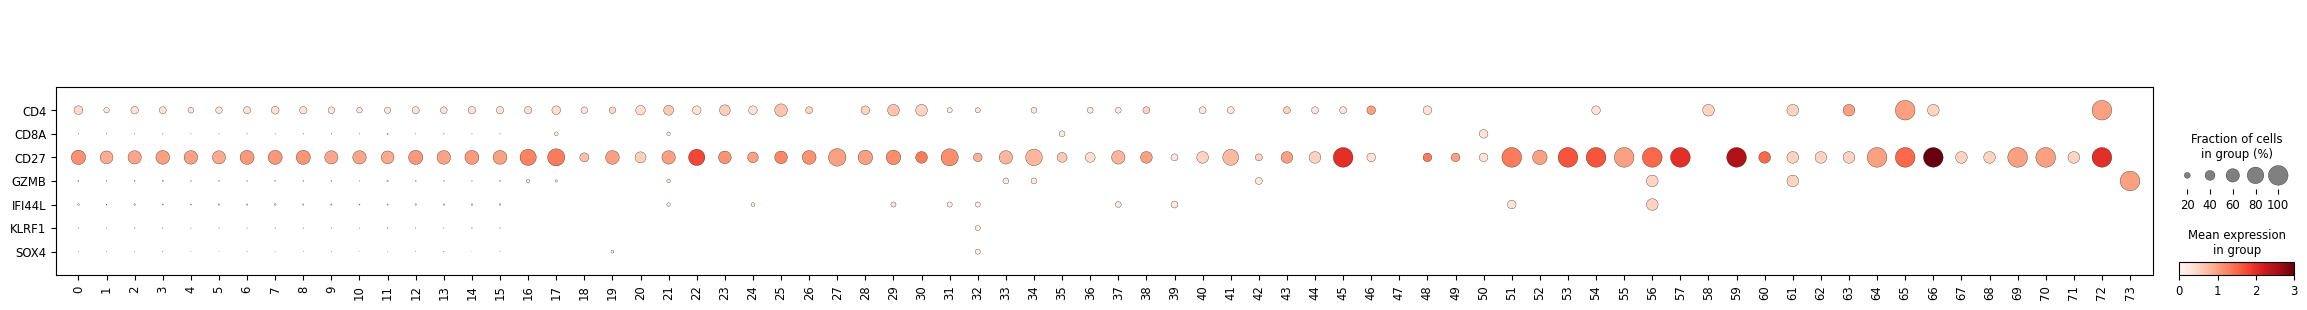

In [41]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [42]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     337674
1     301618
2     294994
3     276649
4     267511
       ...  
58         2
57         2
56         2
72         1
73         1
Name: count, Length: 74, dtype: int64

### Comparison to original labels

In [43]:
adata = add_labels(adata, original_df)

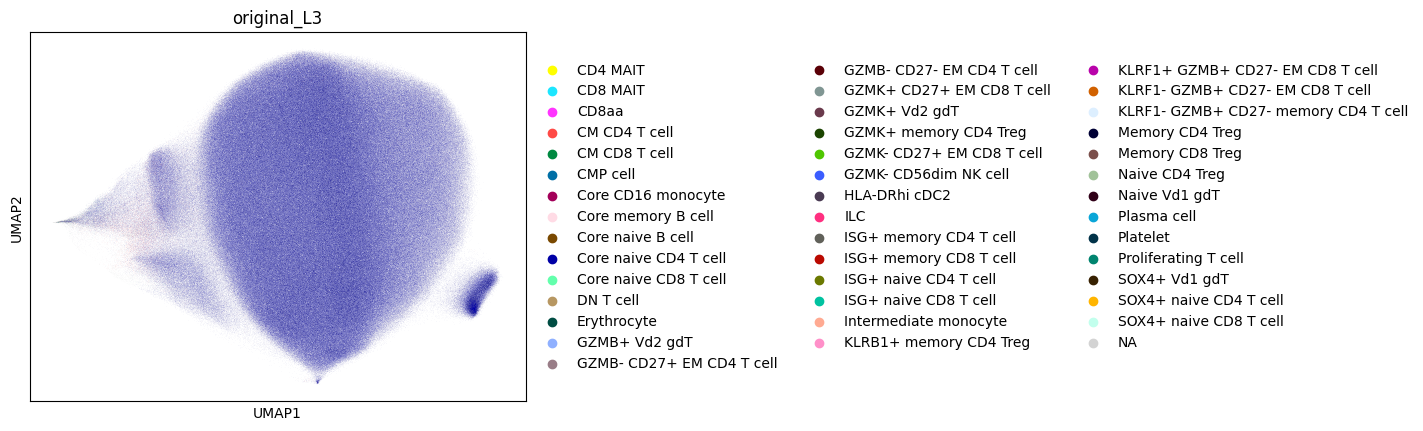

In [44]:
sc.pl.umap(adata, color = 'original_L3')

In [45]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Core naive CD4 T cell                   2595696
NaN                                       59876
CM CD4 T cell                             26042
SOX4+ naive CD4 T cell                     4396
Naive CD4 Treg                             2982
ISG+ naive CD4 T cell                      2598
Core naive CD8 T cell                      2523
GZMB- CD27+ EM CD4 T cell                  2243
CM CD8 T cell                               799
GZMB- CD27- EM CD4 T cell                   413
Naive Vd1 gdT                               331
GZMK+ CD27+ EM CD8 T cell                   190
Erythrocyte                                  69
Memory CD4 Treg                              68
GZMK+ memory CD4 Treg                        68
DN T cell                                    64
SOX4+ naive CD8 T cell                       44
GZMK- CD27+ EM CD8 T cell                    39
CD8 MAIT                                     34
ISG+ memory CD4 T cell                       32
SOX4+ Vd1 gdT               

In [46]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Core naive CD4 T cell                   9.618523e-01
NaN                                     2.218745e-02
CM CD4 T cell                           9.650035e-03
SOX4+ naive CD4 T cell                  1.628967e-03
Naive CD4 Treg                          1.105000e-03
ISG+ naive CD4 T cell                   9.627061e-04
Core naive CD8 T cell                   9.349143e-04
GZMB- CD27+ EM CD4 T cell               8.311585e-04
CM CD8 T cell                           2.960747e-04
GZMB- CD27- EM CD4 T cell               1.530399e-04
Naive Vd1 gdT                           1.226542e-04
GZMK+ CD27+ EM CD8 T cell               7.040576e-05
Erythrocyte                             2.556841e-05
Memory CD4 Treg                         2.519785e-05
GZMK+ memory CD4 Treg                   2.519785e-05
DN T cell                               2.371562e-05
SOX4+ naive CD8 T cell                  1.630449e-05
GZMK- CD27+ EM CD8 T cell               1.445171e-05
CD8 MAIT                          

## Review GZMB- CD27- EM CD4 T cell

In [47]:
cell_type = 'GZMB- CD27- EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [48]:
type_uuid

'41bfbba7-09c6-48ce-8415-8bb597d3c417'

In [49]:
adata = read_adata_uuid(type_uuid)

### Clustering

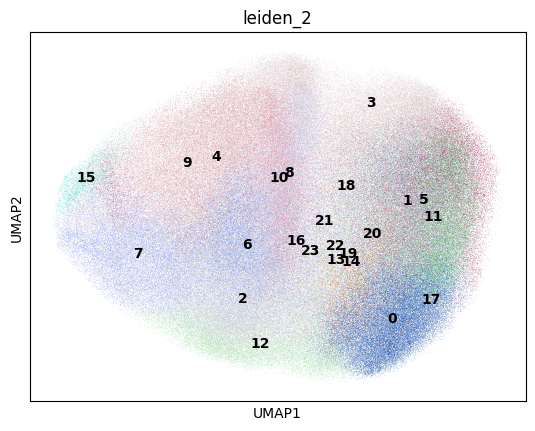

In [50]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

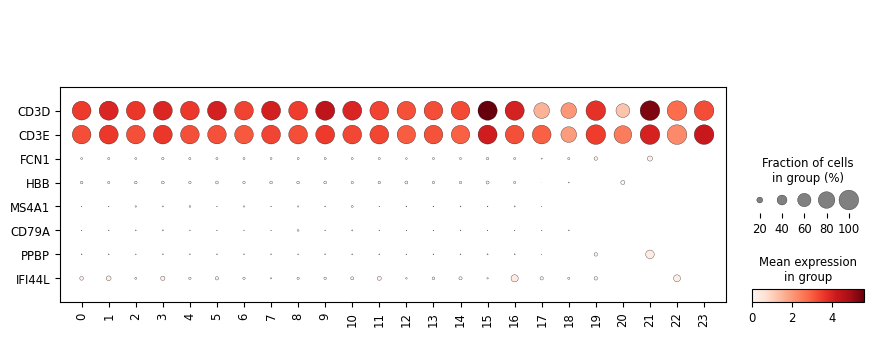

In [51]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

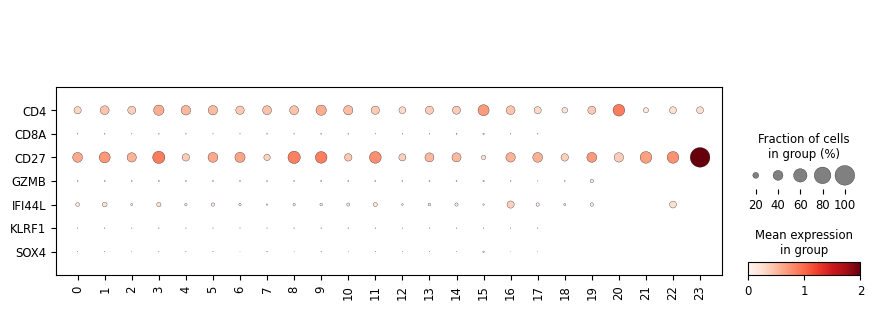

In [52]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

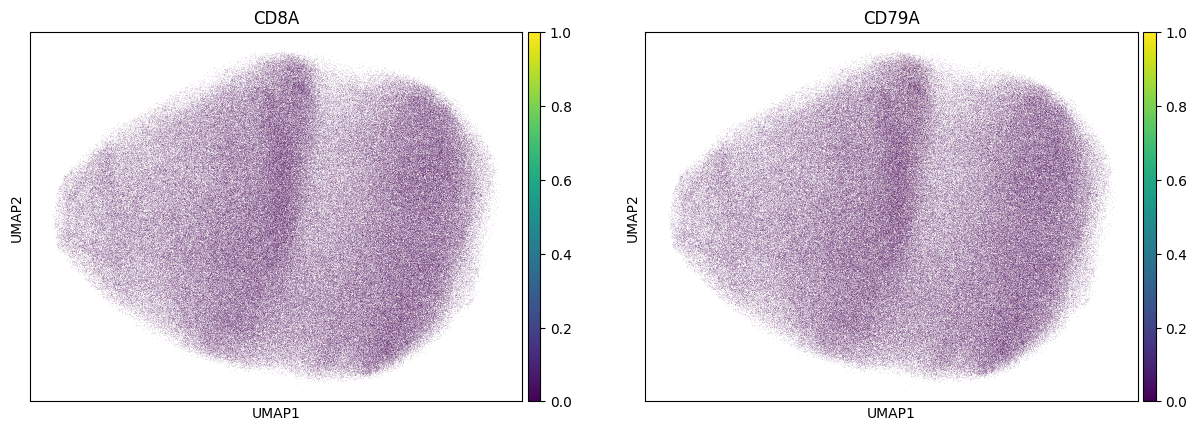

In [53]:
sc.pl.umap(adata, color = ['CD8A','CD79A'], vmax = 'p99')

### Cluster counts

In [54]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     49957
1     42581
2     41675
3     40800
4     39056
5     39053
6     33989
7     33783
8     33753
9     32222
10    31305
11    24080
12    22501
13    17260
14    11079
15     3805
16     2285
17     1267
18       58
19       10
20        8
21        6
22        4
23        4
Name: count, dtype: int64

### Comparison to original labels

In [55]:
adata = add_labels(adata, original_df)

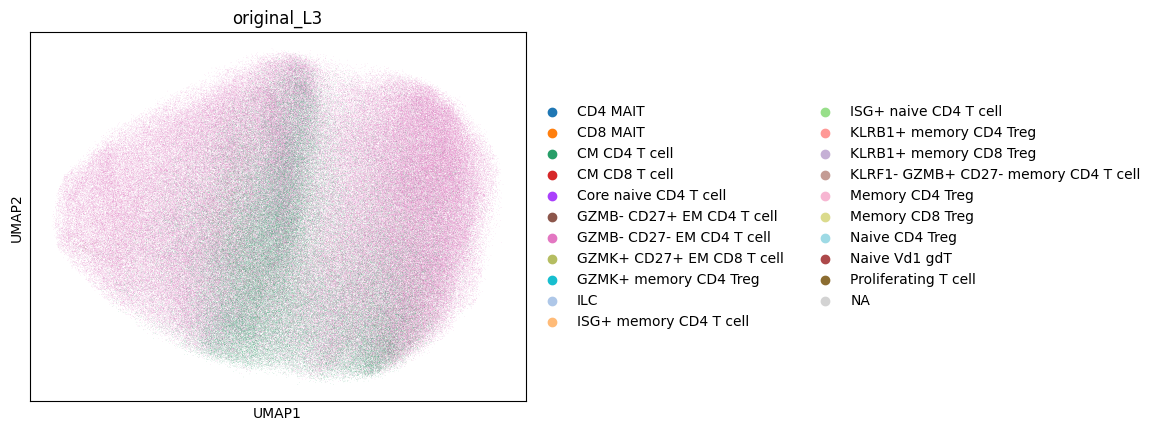

In [56]:
sc.pl.umap(adata, color = 'original_L3')

In [57]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
GZMB- CD27- EM CD4 T cell               353582
CM CD4 T cell                           128955
GZMB- CD27+ EM CD4 T cell                13291
NaN                                       2548
Memory CD4 Treg                            725
KLRB1+ memory CD4 Treg                     699
Core naive CD4 T cell                      300
ISG+ memory CD4 T cell                     254
Naive CD4 Treg                              93
GZMK+ memory CD4 Treg                       34
GZMK+ CD27+ EM CD8 T cell                   17
CD8 MAIT                                     9
CM CD8 T cell                                9
Naive Vd1 gdT                                7
Memory CD8 Treg                              5
CD4 MAIT                                     5
ILC                                          2
KLRB1+ memory CD8 Treg                       2
Proliferating T cell                         2
ISG+ naive CD4 T cell                        1
KLRF1- GZMB+ CD27- memory CD4 T cell         1
N

In [58]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
GZMB- CD27- EM CD4 T cell               0.706400
CM CD4 T cell                           0.257631
GZMB- CD27+ EM CD4 T cell               0.026553
NaN                                     0.005090
Memory CD4 Treg                         0.001448
KLRB1+ memory CD4 Treg                  0.001396
Core naive CD4 T cell                   0.000599
ISG+ memory CD4 T cell                  0.000507
Naive CD4 Treg                          0.000186
GZMK+ memory CD4 Treg                   0.000068
GZMK+ CD27+ EM CD8 T cell               0.000034
CD8 MAIT                                0.000018
CM CD8 T cell                           0.000018
Naive Vd1 gdT                           0.000014
Memory CD8 Treg                         0.000010
CD4 MAIT                                0.000010
ILC                                     0.000004
KLRB1+ memory CD8 Treg                  0.000004
Proliferating T cell                    0.000004
ISG+ naive CD4 T cell                   0.000002
KLRF1- G

## Review GZMB- CD27+ EM CD4 T cell

In [59]:
cell_type = 'GZMB- CD27+ EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [60]:
type_uuid

'376c3b61-fc86-47df-b247-59bbeea0d86a'

In [61]:
adata = read_adata_uuid(type_uuid)

### Clustering

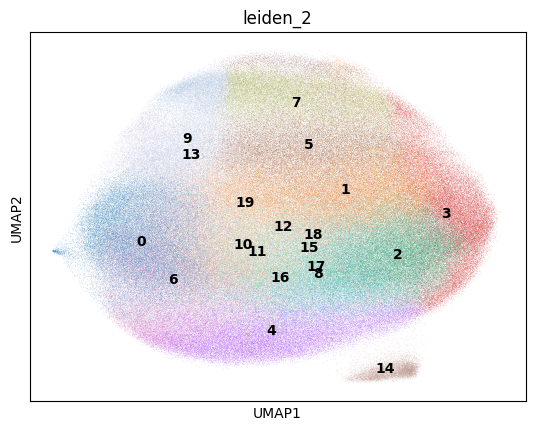

In [62]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

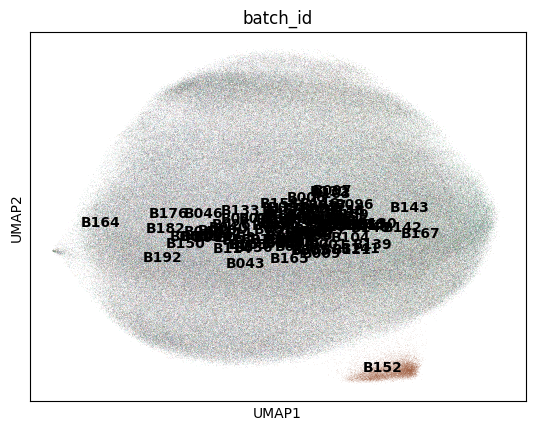

In [63]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

### Marker expression

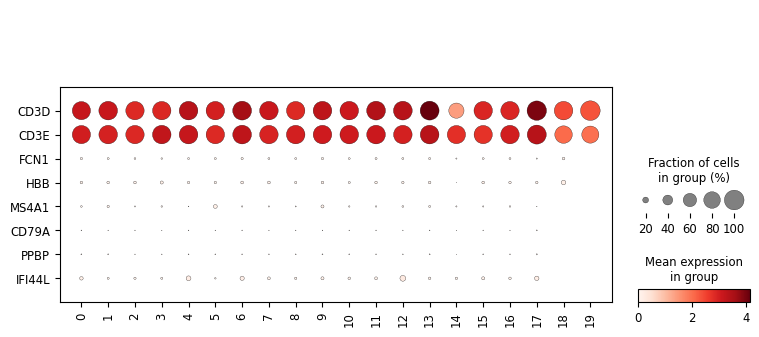

In [64]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

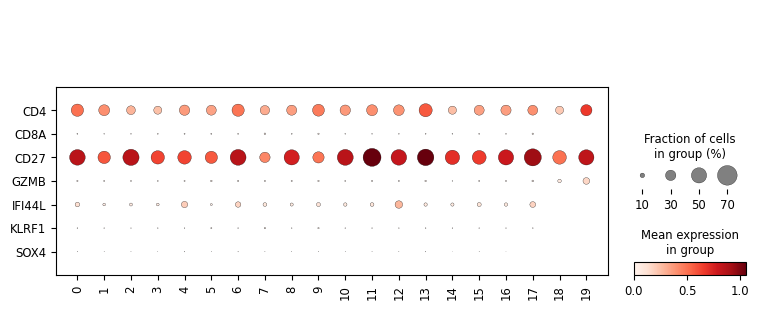

In [65]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [66]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     53439
1     52198
2     51696
3     49266
4     48847
5     47627
6     46994
7     42235
8     41996
9     38596
10    31181
11    21711
12    17786
13    17679
14    14556
15     9557
16     5568
17      218
18       14
19        6
Name: count, dtype: int64

### Comparison to original labels

In [67]:
adata = add_labels(adata, original_df)

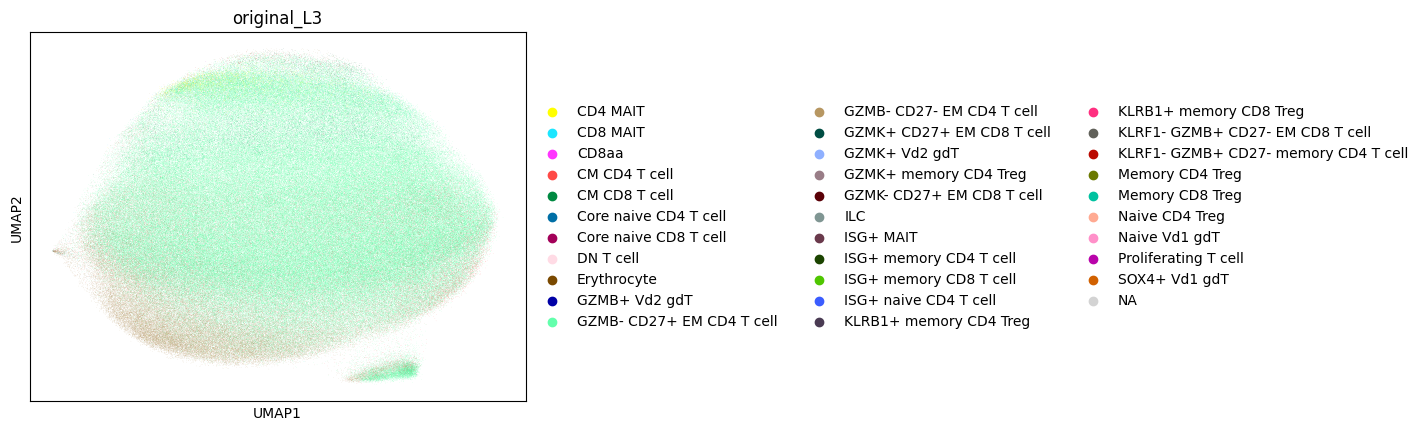

In [68]:
sc.pl.umap(adata, color = 'original_L3')

In [69]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
GZMB- CD27+ EM CD4 T cell               475726
GZMB- CD27- EM CD4 T cell                67693
CM CD4 T cell                            30133
NaN                                       4490
GZMK+ CD27+ EM CD8 T cell                 4422
CD4 MAIT                                  3531
CD8 MAIT                                  1442
CM CD8 T cell                             1334
Core naive CD4 T cell                      601
KLRF1- GZMB+ CD27- memory CD4 T cell       518
GZMK+ memory CD4 Treg                      515
GZMK- CD27+ EM CD8 T cell                  205
ISG+ memory CD4 T cell                     119
GZMK+ Vd2 gdT                               93
ISG+ memory CD8 T cell                      66
KLRB1+ memory CD4 Treg                      63
Memory CD4 Treg                             45
ISG+ MAIT                                   40
Naive CD4 Treg                              36
KLRB1+ memory CD8 Treg                      19
CD8aa                                       15
E

In [70]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
GZMB- CD27+ EM CD4 T cell               0.804719
GZMB- CD27- EM CD4 T cell               0.114507
CM CD4 T cell                           0.050972
NaN                                     0.007595
GZMK+ CD27+ EM CD8 T cell               0.007480
CD4 MAIT                                0.005973
CD8 MAIT                                0.002439
CM CD8 T cell                           0.002257
Core naive CD4 T cell                   0.001017
KLRF1- GZMB+ CD27- memory CD4 T cell    0.000876
GZMK+ memory CD4 Treg                   0.000871
GZMK- CD27+ EM CD8 T cell               0.000347
ISG+ memory CD4 T cell                  0.000201
GZMK+ Vd2 gdT                           0.000157
ISG+ memory CD8 T cell                  0.000112
KLRB1+ memory CD4 Treg                  0.000107
Memory CD4 Treg                         0.000076
ISG+ MAIT                               0.000068
Naive CD4 Treg                          0.000061
KLRB1+ memory CD8 Treg                  0.000032
CD8aa   

## Review ISG+ memory CD4 T cell

In [71]:
cell_type = 'ISG+ memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [72]:
type_uuid

'ebe49b51-902a-451f-bd1d-f3533e46ae94'

In [73]:
adata = read_adata_uuid(type_uuid)

### Clustering

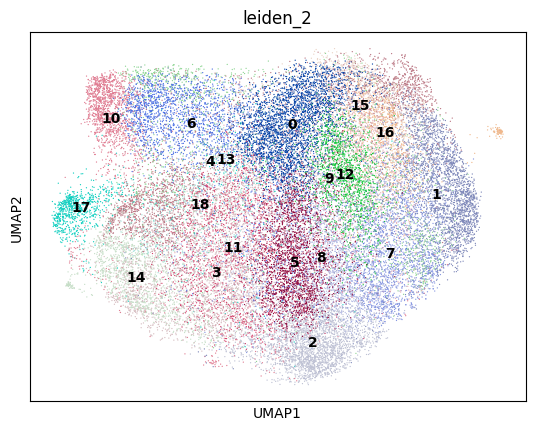

In [74]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

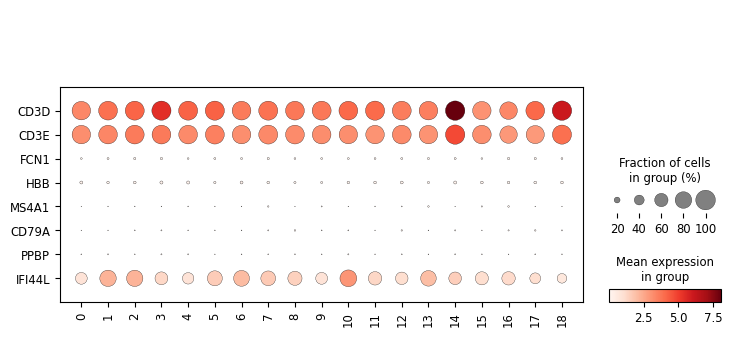

In [75]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

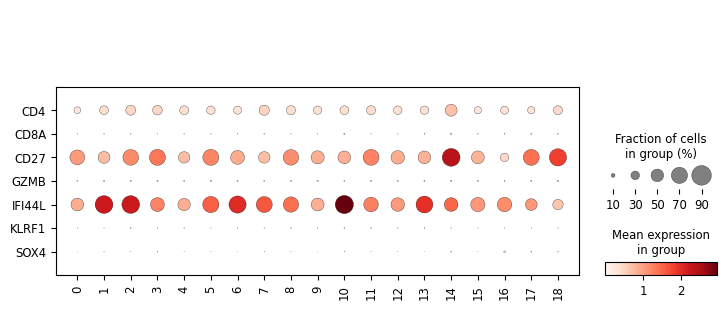

In [76]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [77]:
adata = add_labels(adata, original_df)

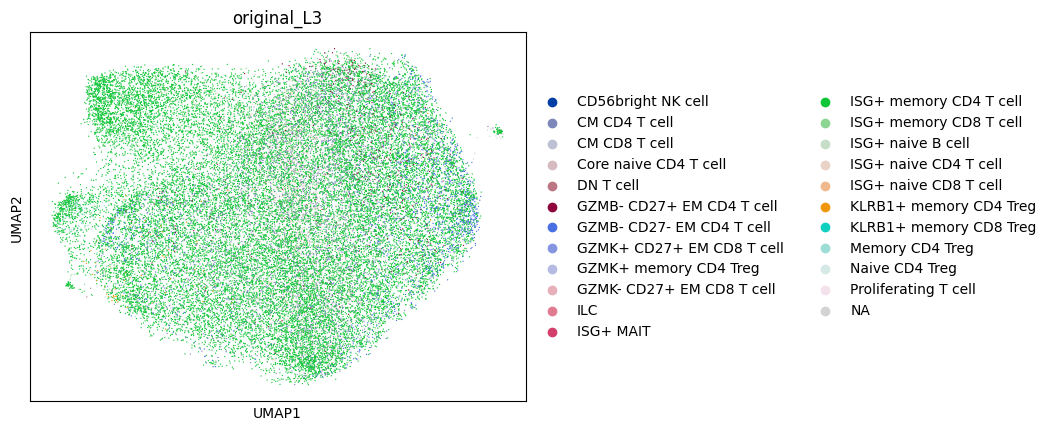

In [78]:
sc.pl.umap(adata, color = 'original_L3')

In [79]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ISG+ memory CD4 T cell       26927
CM CD4 T cell                 3598
ISG+ naive CD4 T cell         2050
GZMB- CD27- EM CD4 T cell     1490
GZMB- CD27+ EM CD4 T cell      476
ISG+ memory CD8 T cell         433
Memory CD4 Treg                196
NaN                            143
KLRB1+ memory CD4 Treg          81
Core naive CD4 T cell           56
GZMK+ memory CD4 Treg           33
Naive CD4 Treg                  26
GZMK+ CD27+ EM CD8 T cell       22
ISG+ naive B cell                5
DN T cell                        4
Proliferating T cell             3
ISG+ MAIT                        2
ILC                              2
GZMK- CD27+ EM CD8 T cell        2
ISG+ naive CD8 T cell            1
KLRB1+ memory CD8 Treg           1
CM CD8 T cell                    1
CD56bright NK cell               1
Name: count, dtype: int64

In [80]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ISG+ memory CD4 T cell       0.757376
CM CD4 T cell                0.101201
ISG+ naive CD4 T cell        0.057660
GZMB- CD27- EM CD4 T cell    0.041909
GZMB- CD27+ EM CD4 T cell    0.013388
ISG+ memory CD8 T cell       0.012179
Memory CD4 Treg              0.005513
NaN                          0.004022
KLRB1+ memory CD4 Treg       0.002278
Core naive CD4 T cell        0.001575
GZMK+ memory CD4 Treg        0.000928
Naive CD4 Treg               0.000731
GZMK+ CD27+ EM CD8 T cell    0.000619
ISG+ naive B cell            0.000141
DN T cell                    0.000113
Proliferating T cell         0.000084
ISG+ MAIT                    0.000056
ILC                          0.000056
GZMK- CD27+ EM CD8 T cell    0.000056
ISG+ naive CD8 T cell        0.000028
KLRB1+ memory CD8 Treg       0.000028
CM CD8 T cell                0.000028
CD56bright NK cell           0.000028
Name: count, dtype: float64

## Review ISG+ naive CD4 T cell

In [81]:
cell_type = 'ISG+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [82]:
type_uuid

'75368892-5147-42d7-b2c3-794166235b1b'

In [83]:
adata = read_adata_uuid(type_uuid)

### Clustering

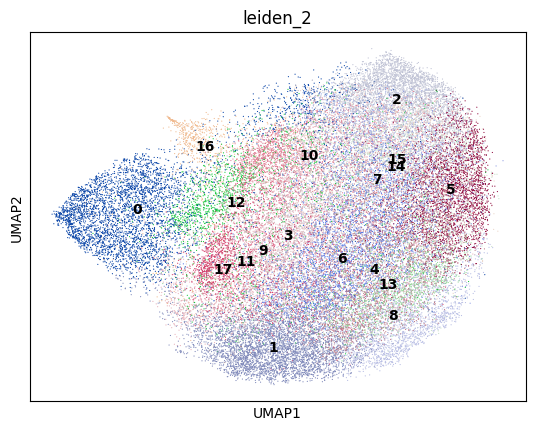

In [84]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

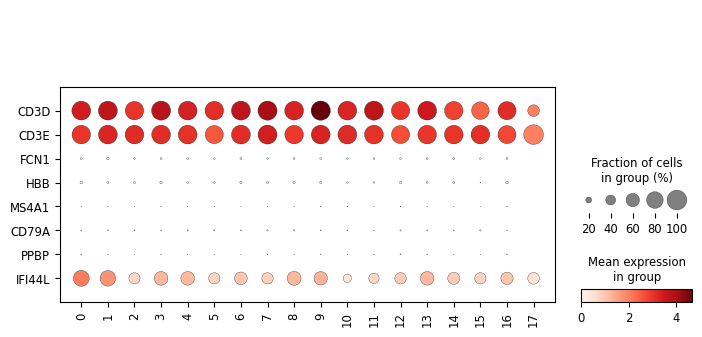

In [85]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

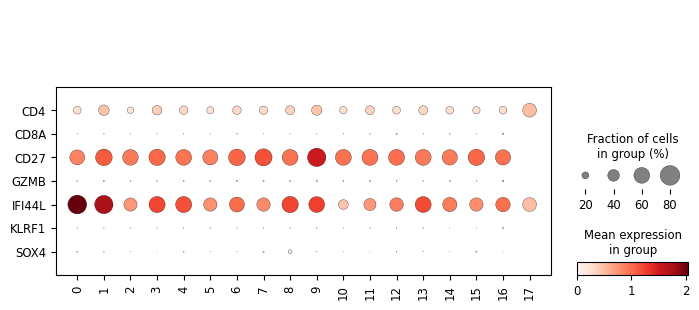

In [86]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [87]:
adata = add_labels(adata, original_df)

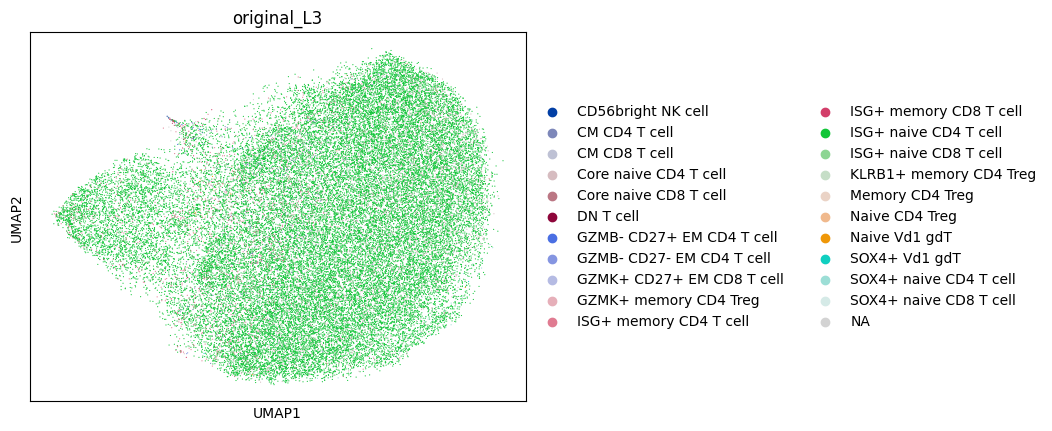

In [88]:
sc.pl.umap(adata, color = 'original_L3')

In [89]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ISG+ naive CD4 T cell        37195
Core naive CD4 T cell         3754
ISG+ memory CD4 T cell        1257
CM CD4 T cell                  361
NaN                            220
Naive CD4 Treg                  94
SOX4+ naive CD4 T cell          77
ISG+ memory CD8 T cell          57
ISG+ naive CD8 T cell           34
GZMB- CD27+ EM CD4 T cell       21
Core naive CD8 T cell           14
Naive Vd1 gdT                   10
CM CD8 T cell                   10
Memory CD4 Treg                  7
GZMK+ memory CD4 Treg            6
GZMK+ CD27+ EM CD8 T cell        4
GZMB- CD27- EM CD4 T cell        4
DN T cell                        3
SOX4+ Vd1 gdT                    3
SOX4+ naive CD8 T cell           2
CD56bright NK cell               2
KLRB1+ memory CD4 Treg           1
Name: count, dtype: int64

In [90]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ISG+ naive CD4 T cell        0.862273
Core naive CD4 T cell        0.087027
ISG+ memory CD4 T cell       0.029140
CM CD4 T cell                0.008369
NaN                          0.005100
Naive CD4 Treg               0.002179
SOX4+ naive CD4 T cell       0.001785
ISG+ memory CD8 T cell       0.001321
ISG+ naive CD8 T cell        0.000788
GZMB- CD27+ EM CD4 T cell    0.000487
Core naive CD8 T cell        0.000325
Naive Vd1 gdT                0.000232
CM CD8 T cell                0.000232
Memory CD4 Treg              0.000162
GZMK+ memory CD4 Treg        0.000139
GZMK+ CD27+ EM CD8 T cell    0.000093
GZMB- CD27- EM CD4 T cell    0.000093
DN T cell                    0.000070
SOX4+ Vd1 gdT                0.000070
SOX4+ naive CD8 T cell       0.000046
CD56bright NK cell           0.000046
KLRB1+ memory CD4 Treg       0.000023
Name: count, dtype: float64

## Review KLRF1- GZMB+ CD27- memory CD4 T cell

In [91]:
cell_type = 'KLRF1- GZMB+ CD27- memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [92]:
type_uuid

'c857e4f7-ed97-4cdb-bed1-fa110fef5d00'

In [93]:
adata = read_adata_uuid(type_uuid)

### Clustering

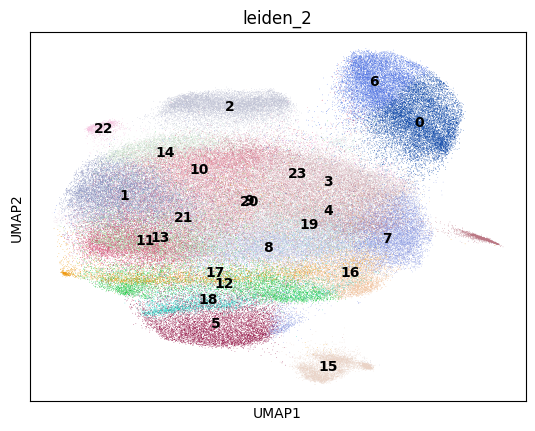

In [94]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

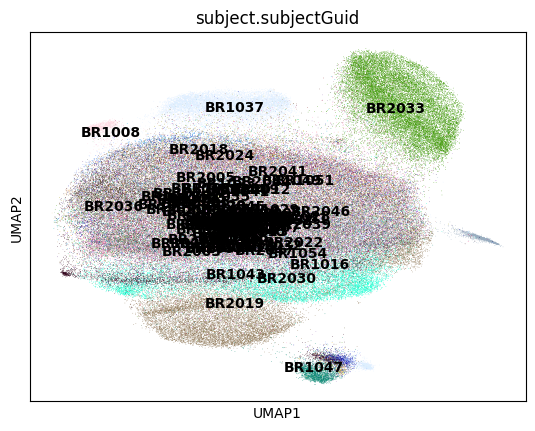

In [95]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

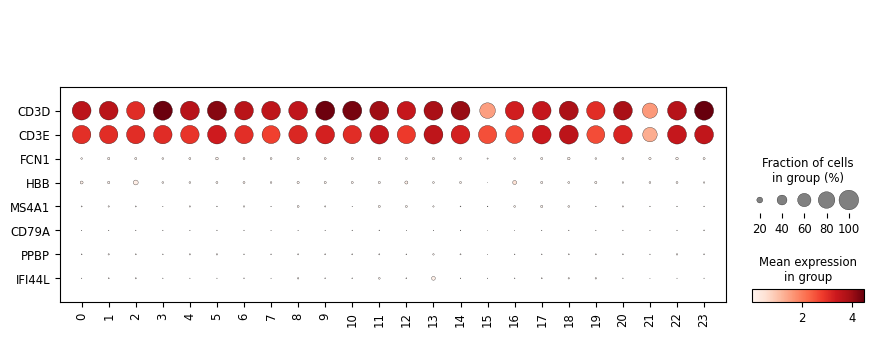

In [96]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

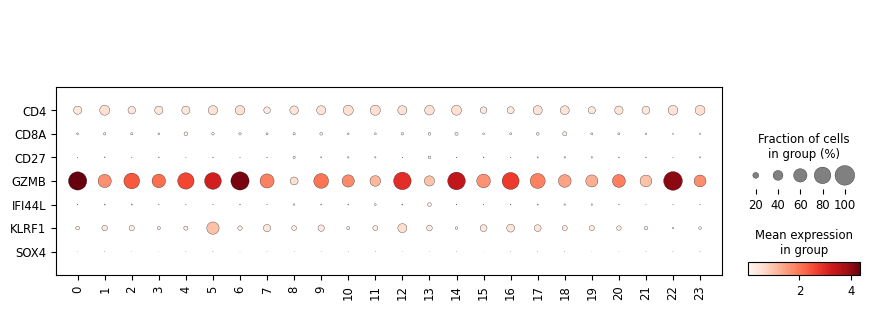

In [97]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [98]:
adata = add_labels(adata, original_df)

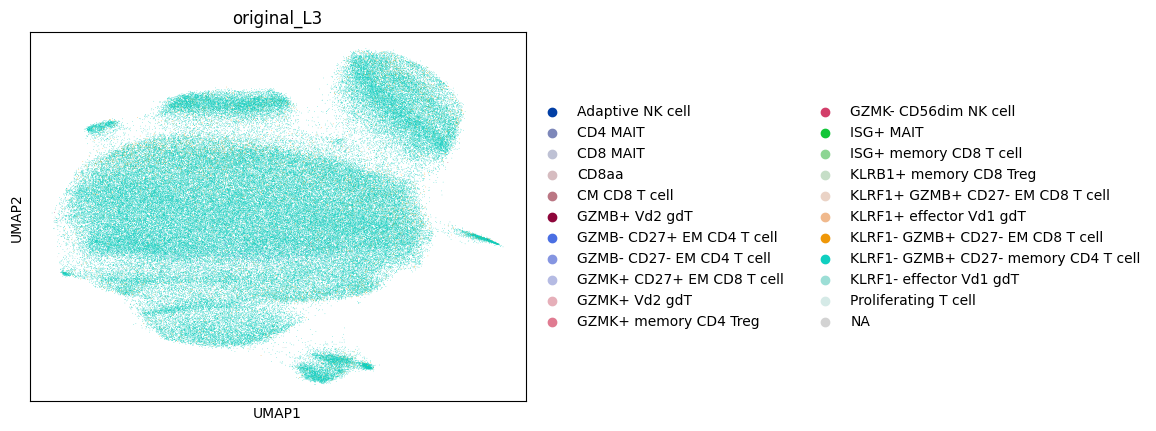

In [99]:
sc.pl.umap(adata, color = 'original_L3')

In [100]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
KLRF1- GZMB+ CD27- memory CD4 T cell    146956
KLRF1- GZMB+ CD27- EM CD8 T cell          4511
NaN                                       2392
GZMB- CD27+ EM CD4 T cell                  465
GZMK+ CD27+ EM CD8 T cell                  365
GZMB+ Vd2 gdT                               64
KLRF1- effector Vd1 gdT                     41
KLRF1+ GZMB+ CD27- EM CD8 T cell            36
GZMB- CD27- EM CD4 T cell                   19
Proliferating T cell                        12
Adaptive NK cell                            10
CD4 MAIT                                     9
KLRF1+ effector Vd1 gdT                      9
GZMK+ Vd2 gdT                                8
KLRB1+ memory CD8 Treg                       4
CD8 MAIT                                     4
ISG+ MAIT                                    2
CM CD8 T cell                                2
CD8aa                                        2
ISG+ memory CD8 T cell                       1
GZMK+ memory CD4 Treg                        1
G

In [101]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
KLRF1- GZMB+ CD27- memory CD4 T cell    0.948630
KLRF1- GZMB+ CD27- EM CD8 T cell        0.029119
NaN                                     0.015441
GZMB- CD27+ EM CD4 T cell               0.003002
GZMK+ CD27+ EM CD8 T cell               0.002356
GZMB+ Vd2 gdT                           0.000413
KLRF1- effector Vd1 gdT                 0.000265
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.000232
GZMB- CD27- EM CD4 T cell               0.000123
Proliferating T cell                    0.000077
Adaptive NK cell                        0.000065
CD4 MAIT                                0.000058
KLRF1+ effector Vd1 gdT                 0.000058
GZMK+ Vd2 gdT                           0.000052
KLRB1+ memory CD8 Treg                  0.000026
CD8 MAIT                                0.000026
ISG+ MAIT                               0.000013
CM CD8 T cell                           0.000013
CD8aa                                   0.000013
ISG+ memory CD8 T cell                  0.000006
GZMK+ me

## Review SOX4+ naive CD4 T cell

In [102]:
cell_type = 'SOX4+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [103]:
type_uuid

'99b22cdd-7506-46b7-9e6c-484cb47d8b72'

In [104]:
adata = read_adata_uuid(type_uuid)

### Clustering

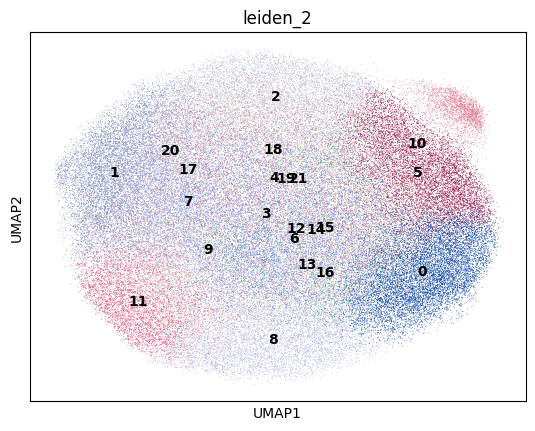

In [105]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

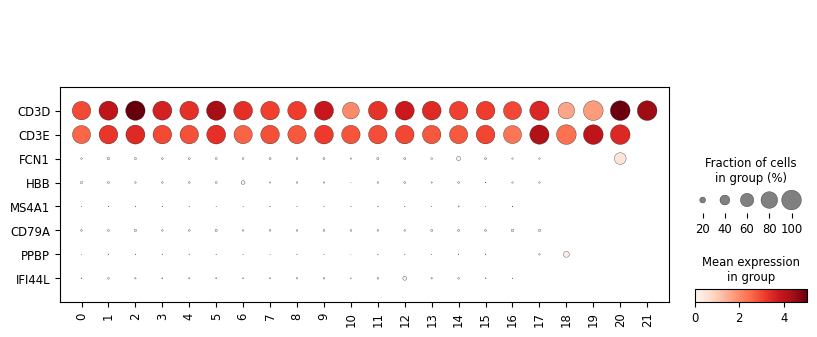

In [106]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

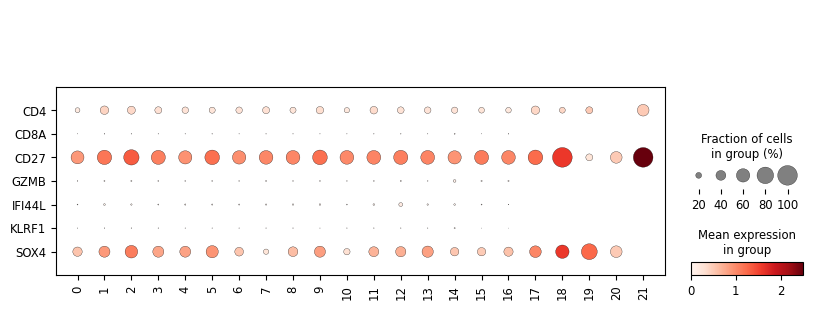

In [107]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [108]:
adata = add_labels(adata, original_df)

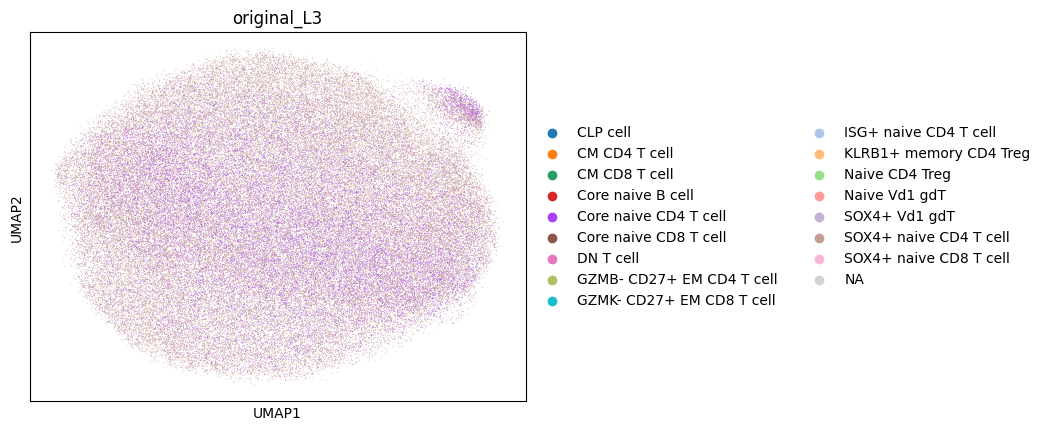

In [109]:
sc.pl.umap(adata, color = 'original_L3')

In [110]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
SOX4+ naive CD4 T cell       74011
Core naive CD4 T cell        21125
NaN                           1916
SOX4+ naive CD8 T cell          98
ISG+ naive CD4 T cell           65
Naive CD4 Treg                  43
Core naive CD8 T cell           29
SOX4+ Vd1 gdT                    9
CM CD4 T cell                    9
CM CD8 T cell                    4
Core naive B cell                3
DN T cell                        2
GZMB- CD27+ EM CD4 T cell        2
CLP cell                         1
Naive Vd1 gdT                    1
KLRB1+ memory CD4 Treg           1
GZMK- CD27+ EM CD8 T cell        1
Name: count, dtype: int64

In [111]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
SOX4+ naive CD4 T cell       0.760491
Core naive CD4 T cell        0.217067
NaN                          0.019688
SOX4+ naive CD8 T cell       0.001007
ISG+ naive CD4 T cell        0.000668
Naive CD4 Treg               0.000442
Core naive CD8 T cell        0.000298
SOX4+ Vd1 gdT                0.000092
CM CD4 T cell                0.000092
CM CD8 T cell                0.000041
Core naive B cell            0.000031
DN T cell                    0.000021
GZMB- CD27+ EM CD4 T cell    0.000021
CLP cell                     0.000010
Naive Vd1 gdT                0.000010
KLRB1+ memory CD4 Treg       0.000010
GZMK- CD27+ EM CD8 T cell    0.000010
Name: count, dtype: float64

In [112]:
os.system('jupyter nbconvert --to html --template pj 13b-Python_review_filtered_L3_cd4_t_cell_data.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 13b-Python_review_filtered_L3_cd4_t_cell_data.ipynb to html
[NbConvertApp] Writing 14136152 bytes to 13b-Python_review_filtered_L3_cd4_t_cell_data.html


0

In [113]:
import session_info
session_info.show()